# Test on 10 images for Clustering

## Load Images

In [1]:
import pydicom
import SimpleITK as sitk
import radiomics
from radiomics import featureextractor
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
from lungmask import LMInferer

Get a list of Study Names

In [2]:
folder = './RBH_standard_recons'

sub_folders = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]
print(sub_folders)

base_path = '/Users/dhruvgupta/Documents/GitHub/BromptonML/RBH_standard_recons'
paths = [os.path.join(base_path, sub_folder) for sub_folder in sub_folders]
paths_dict = {sub_folder: os.path.join(base_path, sub_folder) for sub_folder in sub_folders}
print(paths[1])
print(paths_dict['VK075.7'])



['VK100.1', 'VK080.5', 'VK096.7', 'VK075.7', 'VK102.12', 'VK089.1', 'VK105.1', 'VK107.5', 'VK097.10', 'VK082.5']
/Users/dhruvgupta/Documents/GitHub/BromptonML/RBH_standard_recons/VK080.5
/Users/dhruvgupta/Documents/GitHub/BromptonML/RBH_standard_recons/VK075.7


Load DICOM series at the end folder of branch

In [3]:
def loadImageSeries(base_path):
    # Find the last sub-folder containing files
    for root, dirs, files in os.walk(base_path, topdown=False):
    
        if files:  # Check if files exist in the current folder
            dicom_reader = sitk.ImageSeriesReader()
            dicom_files = dicom_reader.GetGDCMSeriesFileNames(root)
            dicom_reader.SetFileNames(dicom_files)
            try:
                image_out = dicom_reader.Execute()
                return image_out
            except RuntimeError as e:
                raise RuntimeError(f"Error reading DICOM series in folder {root}: {e}")
    raise RuntimeError(f"No valid DICOM series found in {base_path}")


Load images into list - NOT USED

In [4]:
studies = []

for images in range(len(sub_folders)):  # Iterate using range
    studies.append(loadImageSeries(paths[images]))  # Append the result to the list

Created Nested Dictionary with data on each Image Set

In [5]:
# Initialize the nested dictionary
nested_dict = {}

# Iterate over the sub_folders
for sub_folder in sub_folders:
    folder_path = os.path.join(base_path, sub_folder)
    try:
        # Load the image series for the folder
        image_series = loadImageSeries(folder_path)
    except RuntimeError as e:
        print(f"Error loading image series for {sub_folder}: {e}")
        image_series = None  # Handle failed image loads gracefully
    
    # Populate the nested dictionary
    nested_dict[sub_folder] = {
        "path": folder_path,
        "image": image_series
    }

# Now nested_dict contains the desired structure

Add Pixel Spacing to nested dictionary

In [6]:
for top_level in nested_dict:
    nested_dict[top_level]['Voxel Spacing'] = nested_dict[top_level]['image'].GetSpacing()

In [7]:
print(nested_dict['VK082.5']['Voxel Spacing'])

(0.57421875, 0.57421875, 0.7)


Add Image Intensity range to Nested Dictionary

In [8]:
# Calculate intensity range if metadata is not available
stats = sitk.StatisticsImageFilter()

for top_level in nested_dict:

    stats.Execute(nested_dict[top_level]['image'])
    nested_dict[top_level]['Intensity Range'] = (stats.GetMinimum(), stats.GetMaximum())

In [9]:
print(nested_dict['VK075.7']['Intensity Range'])

(-1024.0, 2450.0)


### Plot the Voxel Spacing of all images

In [10]:
# Extract all values for a specific key at the second level
key_to_extract = "Voxel Spacing"
voxel_spacings = [sub_dict[key_to_extract] for sub_dict in nested_dict.values()]


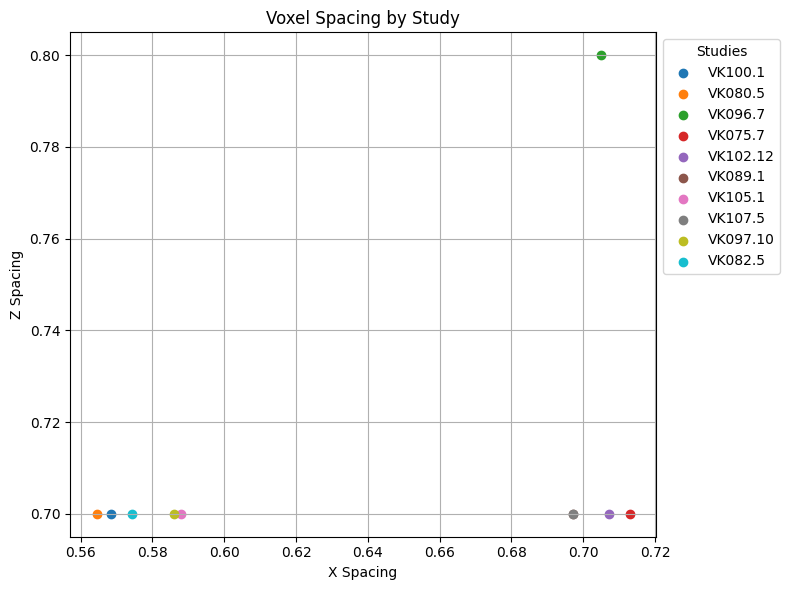

In [11]:
# Extract x and z spacings
x_spacings = [spacing[0] for spacing in voxel_spacings]
z_spacings = [spacing[2] for spacing in voxel_spacings]
labels = list(nested_dict.keys())


# Define colors for each key
colors = plt.cm.tab10(range(len(labels)))  # Use a colormap (10 colors max)

# Create the plot
plt.figure(figsize=(8, 6))
for i, key in enumerate(labels):
    plt.scatter(x_spacings[i], z_spacings[i], color=colors[i], label=key)

# Add labels and legend
plt.xlabel("X Spacing")
plt.ylabel("Z Spacing")
plt.title("Voxel Spacing by Study")
plt.legend(title="Studies", loc="upper left", bbox_to_anchor=(1, 1))  # Color-coded legend
plt.grid(True)
plt.tight_layout()  # Adjust layout for readability
plt.show()

### Plot the image intensity of all images

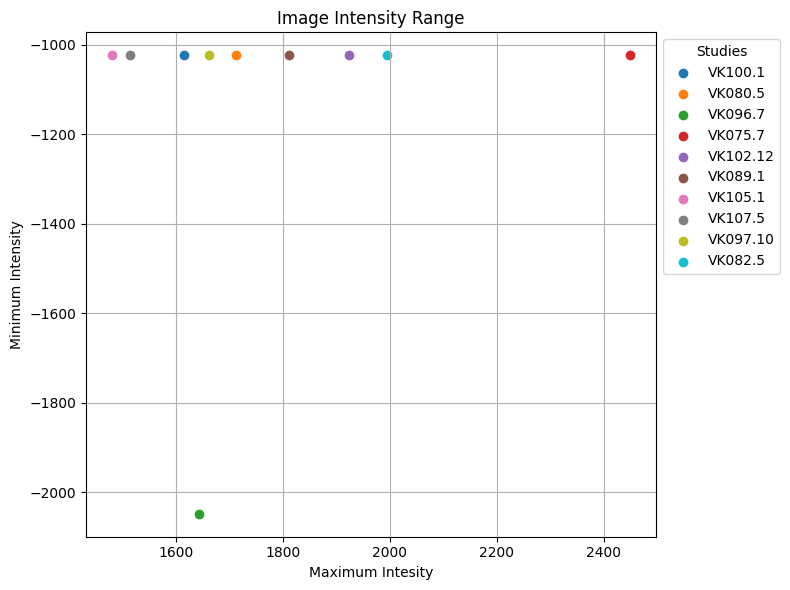

In [12]:
intensities = [sub_dict["Intensity Range"] for sub_dict in nested_dict.values()]

min_intense = [intense[0] for intense in intensities]
max_intense = [intense[1] for intense in intensities]

# Define colors for each key
colors = plt.cm.tab10(range(len(labels)))  # Use a colormap (10 colors max)

# Create the plot
plt.figure(figsize=(8, 6))
for i, key in enumerate(labels):
    plt.scatter(max_intense[i], min_intense[i], color=colors[i], label=key)

# Add labels and legend
plt.xlabel("Maximum Intesity")
plt.ylabel("Minimum Intensity")
plt.title("Image Intensity Range")
plt.legend(title="Studies", loc="upper left", bbox_to_anchor=(1, 1))  # Color-coded legend
plt.grid(True)
plt.tight_layout()  # Adjust layout for readability
plt.show()

Add image dimensions

In [25]:
for top_level in nested_dict:
    nested_dict[top_level]['size'] = nested_dict[top_level]['image'].GetSize()

## Segment Studies

In [26]:
import pprint

pp = pprint.PrettyPrinter(indent=2)
pp.pprint(nested_dict)

{ 'VK075.7': { 'Intensity Range': (-1024.0, 2450.0),
               'Voxel Spacing': (0.712890625, 0.712890625, 0.7000000000000001),
               'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x30a76d860> >,
               'path': '/Users/dhruvgupta/Documents/GitHub/BromptonML/RBH_standard_recons/VK075.7',
               'size': (512, 512, 434)},
  'VK080.5': { 'Intensity Range': (-1024.0, 1712.0),
               'Voxel Spacing': (0.564453125, 0.564453125, 0.7000000000000001),
               'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x30a76c870> >,
               'path': '/Users/dhruvgupta/Documents/GitHub/BromptonML/RBH_standard_recons/VK080.5',
               'size': (512, 512, 404)},
  'VK082.5': { 'Intensity Range': (-1024.0, 1995.0),
               'Voxel Spacing': (0.57421875, 0.57421875, 0.7),
               'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::

Create function that segments 3D CT image

In [14]:
def lungSegmentation3D(image):
    
    imageArray = sitk.GetArrayFromImage(image)
    #load segmentation alg
    inferer = LMInferer()
    mask = inferer.apply(image)

    #do not differentiate l / right lung
    mask = np.where(mask == 2,1,mask )

    segmentation = np.where(mask == 1, imageArray, 0)

    return segmentation




Test segmentation of first image

In [15]:
seg_1 = lungSegmentation3D(nested_dict['VK075.7']['image'])

np.save("VK075.7_segmented.npy",seg_1)

lungmask 2024-11-25 16:27:33 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


 97%|█████████▋| 21/21.7 [00:10<00:00,  2.22it/s]/Users/dhruvgupta/miniconda3/envs/BromptonML/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
101%|██████████| 22/21.7 [00:10<00:00,  2.09it/s]

lungmask 2024-11-25 16:27:46 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 52.26it/s]


Test Visualisation

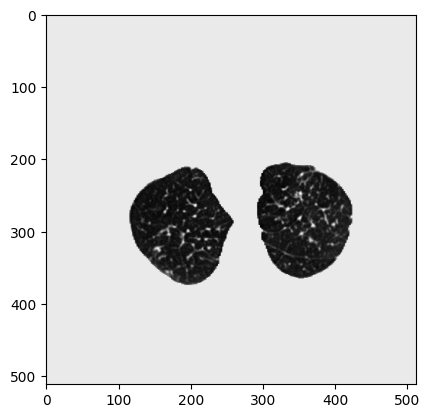

In [36]:
image_array3d = np.load("VK075.7_segmented.npy")

plt.imshow(image_array3d[370,:,:], cmap='grey')


In [37]:
def crop_around_nonzero(image):
    """
    Crops a 3D image array around the non-zero region.
    
    Parameters:
        image (numpy.ndarray): A 3D array representing the image.
        
    Returns:
        cropped_image (numpy.ndarray): The cropped 3D image.
        bounding_box (tuple): The coordinates of the cropping bounding box.
    """
    # Find the non-zero coordinates along each axis
    non_zero_coords = np.argwhere(image > 0)
    min_coords = non_zero_coords.min(axis=0)  # Minimum along each axis
    max_coords = non_zero_coords.max(axis=0) + 1  # Maximum along each axis (inclusive)
    
    # Crop the image
    cropped_image = image[min_coords[0]:max_coords[0],  # Along depth (z)
                          min_coords[1]:max_coords[1],  # Along height (y)
                          min_coords[2]:max_coords[2]]  # Along width (x)
    
    # Return the cropped image and the bounding box
    bounding_box = (min_coords, max_coords)
    return cropped_image, bounding_box

In [38]:
cropped_image, bbox = crop_around_nonzero(image_array3d)

print("Bounding box:", bbox)
print("Original shape:", image_array3d.shape)
print("Cropped shape:", cropped_image.shape)

Bounding box: (array([ 42, 126,  46]), array([419, 408, 482]))
Original shape: (434, 512, 512)
Cropped shape: (377, 282, 436)


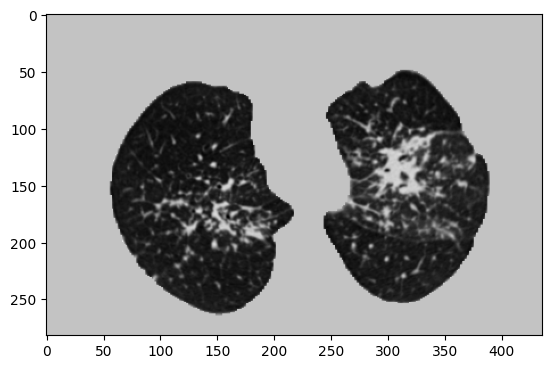

In [47]:
plt.imshow(cropped_image[300,:,:], cmap='grey')

### Run segmentation on all images

In [48]:
for top_level in nested_dict:
    nested_dict[top_level]['segmentedImage'] = lungSegmentation3D(nested_dict[top_level]['image'])

lungmask 2024-11-25 16:52:22 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


20it [00:09,  2.03it/s]                           

lungmask 2024-11-25 16:52:35 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 1147.87it/s]


lungmask 2024-11-25 16:52:38 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


21it [00:09,  2.19it/s]                          

lungmask 2024-11-25 16:52:50 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 89.84it/s]


lungmask 2024-11-25 16:52:53 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


 96%|█████████▋| 19/19.7 [00:09<00:00,  2.23it/s]/Users/dhruvgupta/miniconda3/envs/BromptonML/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
102%|██████████| 20/19.7 [00:09<00:00,  2.14it/s]

lungmask 2024-11-25 16:53:05 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 432.54it/s]


lungmask 2024-11-25 16:53:08 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


101%|██████████| 22/21.7 [00:10<00:00,  2.09it/s]

lungmask 2024-11-25 16:53:22 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 104.99it/s]


lungmask 2024-11-25 16:53:25 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


23it [00:10,  2.14it/s]                          

lungmask 2024-11-25 16:53:39 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 261.47it/s]


lungmask 2024-11-25 16:53:43 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


101%|██████████| 24/23.7 [00:11<00:00,  2.01it/s]

lungmask 2024-11-25 16:53:58 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 96.38it/s]


lungmask 2024-11-25 16:54:02 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 20/19.65 [00:09<00:00,  2.04it/s]

lungmask 2024-11-25 16:54:14 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 151.10it/s]


lungmask 2024-11-25 16:54:18 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 23/22.55 [00:11<00:00,  2.03it/s]

lungmask 2024-11-25 16:54:33 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 425.90it/s]


lungmask 2024-11-25 16:54:36 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


100%|██████████| 20/20.0 [00:09<00:00,  2.08it/s]

lungmask 2024-11-25 16:54:49 Postprocessing



100%|██████████| 7/7 [00:00<00:00, 1110.23it/s]


lungmask 2024-11-25 16:54:52 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


100%|██████████| 17/17.0 [00:08<00:00,  2.05it/s]

lungmask 2024-11-25 16:55:03 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 423.54it/s]


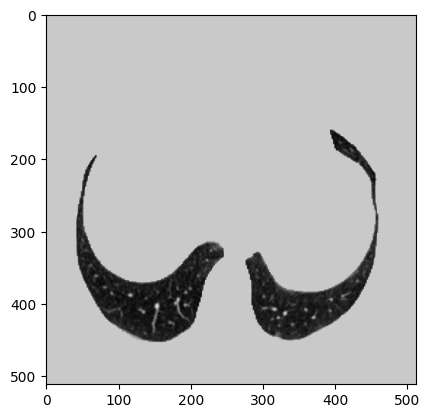

In [52]:
plt.imshow(nested_dict['VK100.1']['segmentedImage'][100,:,:], cmap='grey')